## Inicialización

In [2]:
#Cargamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [3]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go


df = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir el directorio de las imágenes
image_dir = '/datasets/faces/final_files/'

## EDA

In [5]:
df

file_name  real_age
0     000000.jpg         4
1     000001.jpg        18
2     000002.jpg        80
3     000003.jpg        50
4     000004.jpg        17
...          ...       ...
7586  007608.jpg        14
7587  007609.jpg        37
7588  007610.jpg        28
7589  007611.jpg        20
7590  007612.jpg        47

[7591 rows x 2 columns]

In [6]:
df_age_distribution = df.groupby('real_age')['real_age'].count().reset_index(name='count')
df_age_distribution

real_age  count
0          1    149
1          2     88
2          3     25
3          4    101
4          5     87
..       ...    ...
92        94      5
93        95      2
94        96      2
95        97      1
96       100      1

[97 rows x 2 columns]

In [7]:
# Crear el gráfico de barras de la columna 'real_age' con los valores de 'count'
fig = go.Figure(
    data=[go.Bar(
        x=df_age_distribution['real_age'],
        y=df_age_distribution['count'],
        marker=dict(
            color='blue',  # Color de las barras
            line=dict(
                color='black',  # Color del contorno
                width=1  # Ancho del contorno
            )
        )
    )]
)

# Actualizar el layout del gráfico
fig.update_layout(
    title='Distribución de Edades',
    xaxis_title='Edad',
    yaxis_title='Número de Fotografías',
    bargap=0.1  # Espacio entre barras
)

# Mostrar el gráfico
fig.show()

In [8]:
# Estadísticas descriptivas
print(df['real_age'].describe())

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


Found 6832 validated image filenames.


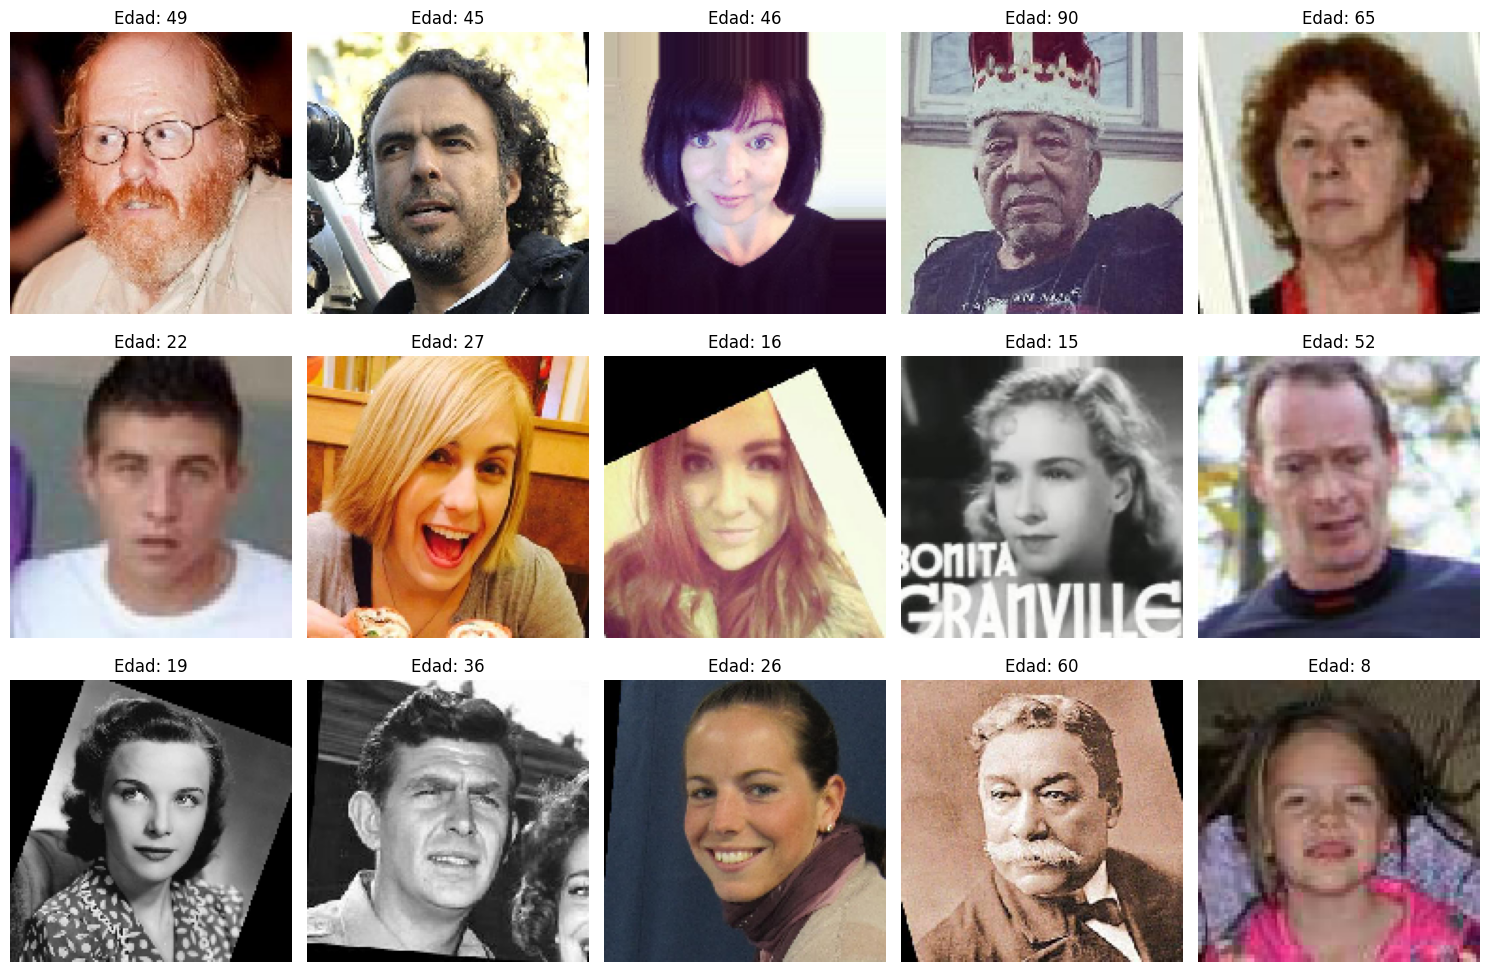

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Cargar el archivo de etiquetas
labels_df = pd.read_csv('/datasets/faces/labels.csv')

# Configurar el generador de datos de imágenes
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)  # Añadir validación opcional

# Crear el generador de datos de entrenamiento
train_gen = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=15,
    class_mode='raw',
    subset='training',
    shuffle=True
)

# Obtener un lote de imágenes y sus etiquetas
images, ages = next(train_gen)

# Configurar el tamaño de la figura
plt.figure(figsize=(15, 10))

# Mostrar las imágenes con sus edades
for i in range(len(images)):
    plt.subplot(3, 5, i + 1)  # 3 filas, 5 columnas
    plt.imshow(images[i])
    plt.title(f'Edad: {int(ages[i])}')
    plt.axis('off')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Conclusiones

Es interesante ver que la mayoria de fotografías esta entre los 15 y 45 años, 
por lo que podría esperarse que el modelo actue mejor en este intervalo de edades.

La media de edad esta en los 31 años, la edad de la persona más joven es de 1 año y la más 
madura es de 100 años. EL 75% de las fotos se encuentra por debajo de la edad de 41 años, por lo que podriamos intuir que
el modelo sea muy bueno en estas zonas.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [10]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [11]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen=ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255
    )# coloca tu código aquí
    train_gen_flow=train_datagen.flow_from_directory(
        dataframe=labels,
        directory=path + "final_files/",
        x_col="file_name",
        y_col="real_name",
        target_size=(224, 224),
        batch_size=16,
        class_mode="raw",
        subset="training",
        seed=12345
    )

    return train_gen_flow

In [12]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen=ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
    )# coloca tu código aquí
    test_gen_flow=test_datagen.flow_from_directory(
        dataframe=labels,
        directory=path + "final_files/",
        x_col="file_name",
        y_col="real_name",
        target_size=(224, 224),
        batch_size=16,
        class_mode="raw",
        subset="validation",
        seed=12345
    )    # coloca tu código aquí

    return test_gen_flow

In [13]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    # coloca tu código aquí

    return model

In [14]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)    # # coloca tu código aquí

    return model

## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [15]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = 'image_regressor'
"""
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

def load_train(path):
   
    
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+'labels.csv'),
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset ='training',
        seed=12345) 

    return train_gen_flow
    
def load_test(path):

    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+'labels.csv'),
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset ='validation',
        seed=12345) 

    return test_gen_flow
    
def create_model(input_shape=(224, 224, 3)):

    backbone = ResNet50(input_shape=input_shape,
                        classes=1000,
                        include_top=False,
                        weights='imagenet')
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mae', optimizer=Adam(lr=0.0001), metrics=['mae'])

    return model
    
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 
        
   
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)
   
    return model
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### El resultado

Coloca el resultado de la plataforma GPU como una celda Markdown aquí.

## Conclusiones

# Lista de control

- [ ]  El Notebook estaba abierto 
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución
- [ ]  Se realizó el análisis exploratorio de datos 
- [ ]  Los resultados del análisis exploratorio de datos se presentan en el notebook final 
- [ ]  El valor EAM del modelo no es superior a 8 
- [ ]  El código de entrenamiento del modelo se copió en el notebook final 
- [ ]  El resultado de entrenamiento del modelo se copió en el notebook final 
- [ ] Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo